In [1]:
pip install torch pandas scikit-learn pytorch-tabnet shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


import pickle
import pandas as pd
import os
df = pd.read_pickle('data/trainingData.pkl')

# 1. Identify your target and feature columns
target = 'preis_miet_best'
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in the DataFrame.")

features = [col for col in df.columns if col != target]



# Convert dataframe to numpy arrays
X = df[features].values
y = df[target].values.reshape(-1, 1)

# --- Split the data into training and validation sets ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData preparation complete!")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Data preparation complete!
Training data shape: (7906, 101)
Validation data shape: (1977, 101)


In [ ]:
from sklearn.model_selection import ParameterGrid
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Define a grid of hyperparameters to search
param_grid = {
    'n_d': [16, 24, 32, 40, 48],
    'n_a': [ 64, 128, 192, 256, 320],
    'n_steps': [1, 2, 3, 4, 5],
    'gamma': [0.7, 0.8, 0.9, 1, 1.1, 1.2],
    'cat_emb_dim': [0],
    'optimizer_params': [ {'lr': 0.01}, {'lr': 0.015} , {'lr': 0.02}, {'lr': 0.005}, ],
}

best_rmse = float('inf')
best_params = None
results = []

for params in ParameterGrid(param_grid):
    tabnet_params_tune = tabnet_params.copy()
    tabnet_params_tune.update(params)
    reg = TabNetRegressor(**tabnet_params_tune)
    reg.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_name=['validation'],
        eval_metric=['rmse'],
        max_epochs=200,
        patience=5,
        batch_size=1024,
        virtual_batch_size=128
    )
    preds = reg.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds))
    results.append((params, rmse_val))
    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_params = params


In [ ]:
print("Best RMSE:", best_rmse)
print("Best Params:", best_params)

In [35]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# --- Define the TabNet Regressor ---
# You can tune these hyperparameters
tabnet_params = dict(
  
     # Size of the embedding for categorical features
    n_d=39,         # Dimension of the prediction layer
    n_a=314,         # Dimension of the attention layer
    n_steps=1,     # Number of decision steps
    gamma=0.5,     # Coefficient for feature reusage
    n_independent=2,
    n_shared=2,
    seed=42,
    verbose=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.0175),
    scheduler_params={"step_size":10, "gamma":1.1},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # or 'entmax'
)

regressor = TabNetRegressor(**tabnet_params)

# --- Train the model ---
max_epochs = 1000 # You can increase this for better performance

regressor.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['validation'],
    eval_metric=['rmse'], # Root Mean Squared Error
    max_epochs=max_epochs,
    patience=100, # Stop training if validation metric doesn't improve for 10 epochs
    batch_size=1024, # Batch size for training
    virtual_batch_size=128, # Virtual batch size for the TabNet model
)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.01291| validation_rmse: 46.76945|  0:00:00s
epoch 1  | loss: 1.74074 | validation_rmse: 22.33834|  0:00:00s
epoch 2  | loss: 0.85185 | validation_rmse: 11.52233|  0:00:00s
epoch 3  | loss: 0.659   | validation_rmse: 10.79314|  0:00:01s
epoch 4  | loss: 0.53481 | validation_rmse: 9.78894 |  0:00:01s
epoch 5  | loss: 0.46378 | validation_rmse: 10.32532|  0:00:01s
epoch 6  | loss: 0.41483 | validation_rmse: 6.24121 |  0:00:02s
epoch 7  | loss: 0.35884 | validation_rmse: 4.184   |  0:00:02s
epoch 8  | loss: 0.31376 | validation_rmse: 4.16883 |  0:00:02s
epoch 9  | loss: 0.29891 | validation_rmse: 3.47867 |  0:00:03s
epoch 10 | loss: 0.31811 | validation_rmse: 4.548   |  0:00:03s
epoch 11 | loss: 0.28481 | validation_rmse: 1.99741 |  0:00:03s
epoch 12 | loss: 0.26176 | validation_rmse: 1.66009 |  0:00:04s
epoch 13 | loss: 0.25294 | validation_rmse: 1.70732 |  0:00:04s
epoch 14 | loss: 0.23316 | validation_rmse: 1.62788 |  0:00:04s
epoch 15 | loss: 0.23997 | validation_rm

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [41]:
# Make predictions on the validation set
y_pred = regressor.predict(X_val)

# Evaluate the performance
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"\nValidation RMSE: {rmse}")

# You can also inspect feature importances
print("\nFeature Importances:")
print(pd.DataFrame({'feature': features, 'importance': regressor.feature_importances_}))


Validation RMSE: 0.3462512510043211

Feature Importances:
                          feature  importance
0                        luftrtng    0.002324
1                          p_poli    0.012668
2                           p_apo    0.000000
3                      v_breitb50    0.000000
4                    v_breitb1000    0.000000
..                            ...         ...
96   Buildings_With_Height_Levels    0.000000
97                         Health    0.000000
98                        Finance    0.000000
99                   All_Highways    0.000000
100                     Cycleways    0.005885

[101 rows x 2 columns]


PermutationExplainer explainer: 201it [02:07,  1.47it/s]                         
/var/folders/2l/0fwydqp17hxc2fffhxkn76zh0000gn/T/ipykernel_15621/1116682154.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


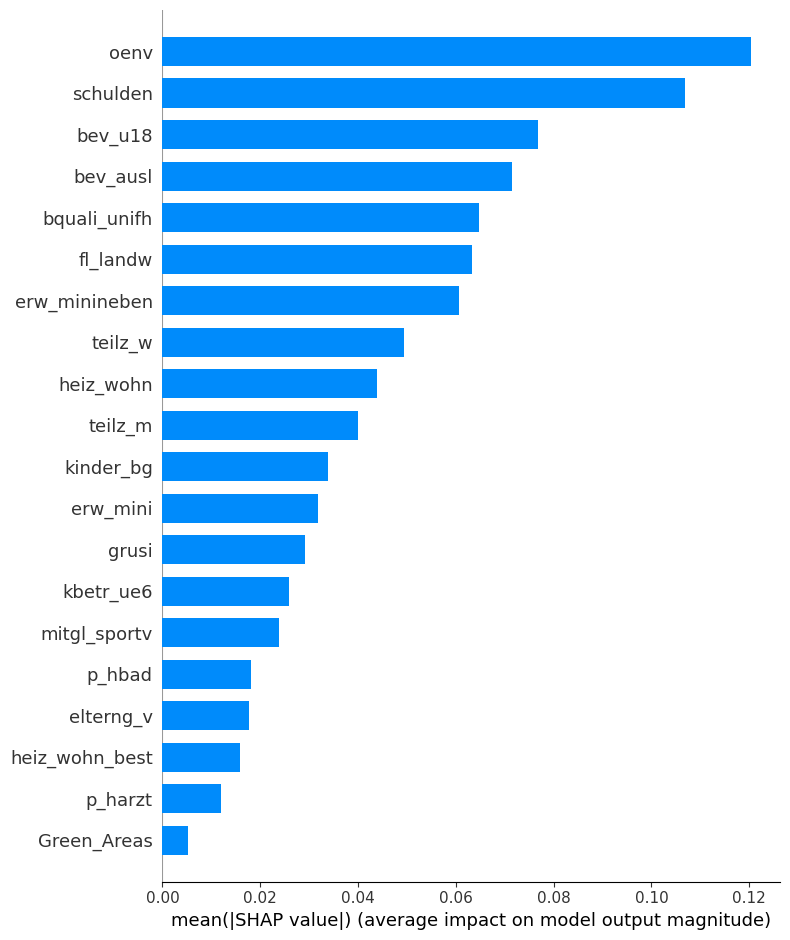

In [43]:

import shap

# Define top_n and compute indices of top features by TabNet importance
top_n = 20
indices = np.argsort(tabnet_importances)[::-1]  # descending order

# Select the top N most important feature indices and names
top_features_idx = indices[:top_n]
top_features = [features[i] for i in top_features_idx]

# Prepare a sample of the validation set for SHAP (to speed up computation)
X_val_sample = X_val[:200]

# SHAP expects a function that outputs predictions
def tabnet_predict(X):
    return regressor.predict(X)

# Create a SHAP explainer for the TabNet model
explainer = shap.Explainer(tabnet_predict, X_train, feature_names=features)

# Calculate SHAP values for the sample
shap_values = explainer(X_val_sample)

# Plot summary for the top features
shap.summary_plot(
    shap_values.values[:, top_features_idx],
    X_val_sample[:, top_features_idx],
    feature_names=top_features,
    plot_type="bar"
)

<Figure size 1000x800 with 0 Axes>

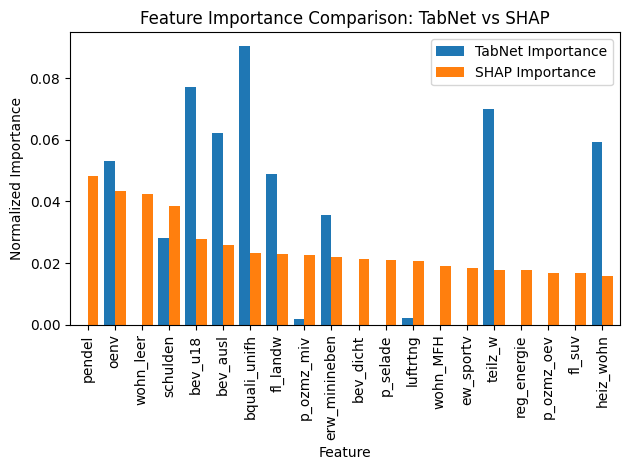

In [48]:
import matplotlib.pyplot as plt

# TabNet feature importances
tabnet_importances = regressor.feature_importances_

# SHAP feature importances (mean absolute value across samples)
shap_importances = np.abs(shap_values.values).mean(axis=0)

# Normalize both importances for comparison
tabnet_importances_norm = tabnet_importances / tabnet_importances.sum()
shap_importances_norm = shap_importances / shap_importances.sum()

# Create a DataFrame for comparison
importances_df = pd.DataFrame({
    'Feature': features,
    'TabNet Importance': tabnet_importances_norm,
    'SHAP Importance': shap_importances_norm
}).set_index('Feature')

# Sort by SHAP importance for better visualization
importances_df = importances_df.sort_values('SHAP Importance', ascending=False)

# Plot comparison
plt.figure(figsize=(10, 8))
importances_df[['TabNet Importance', 'SHAP Importance']].head(20).plot(kind='bar', width=0.8)
plt.title('Feature Importance Comparison: TabNet vs SHAP')
plt.ylabel('Normalized Importance')
plt.tight_layout()
plt.show()

Top features by SHAP importance:
1. bquali_unifh
2. bev_u18
3. teilz_w
4. bev_ausl
5. Green_Areas
6. heiz_wohn
7. oenv
8. fl_landw
9. grusi
10. heiz_wohn_best
11. mitgl_sportv
12. erw_minineben
13. erw_mini
14. kinder_bg
15. schulden
16. kbetr_ue6
17. teilz_m
18. p_hbad
19. p_harzt
20. elterng_v

SHAP summary plot shows the impact of each feature on the model's prediction for the sample data.
Positive SHAP values indicate a feature increases the predicted rent price, while negative values decrease it.
The further from zero, the greater the impact. Color shows feature value (red=high, blue=low).


/var/folders/2l/0fwydqp17hxc2fffhxkn76zh0000gn/T/ipykernel_15621/1752038834.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


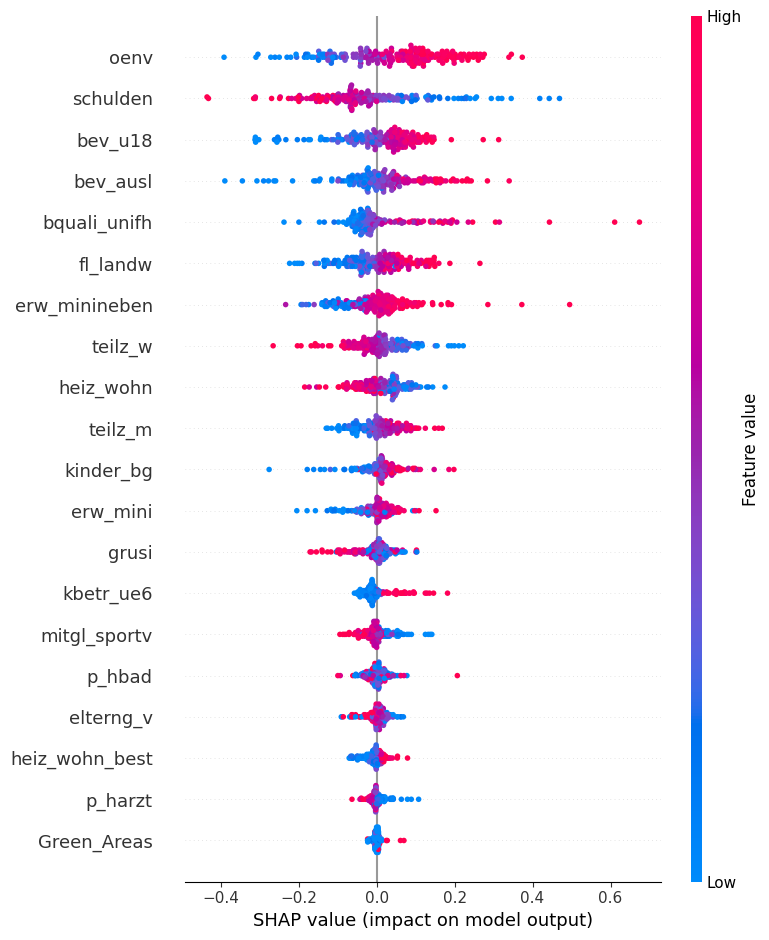

In [47]:
import shap

# Display the SHAP summary plot for the top N most important features

print("Top features by SHAP importance:")
for i, feat in enumerate(top_features):
    print(f"{i+1}. {feat}")

print("\nSHAP summary plot shows the impact of each feature on the model's prediction for the sample data.")
print("Positive SHAP values indicate a feature increases the predicted rent price, while negative values decrease it.")
print("The further from zero, the greater the impact. Color shows feature value (red=high, blue=low).")

# Show the summary plot again for reference
shap.summary_plot(
    shap_values.values[:, top_features_idx],
    X_val_sample[:, top_features_idx],
    feature_names=top_features,
    plot_type="dot"
)

/var/folders/2l/0fwydqp17hxc2fffhxkn76zh0000gn/T/ipykernel_15621/638335503.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


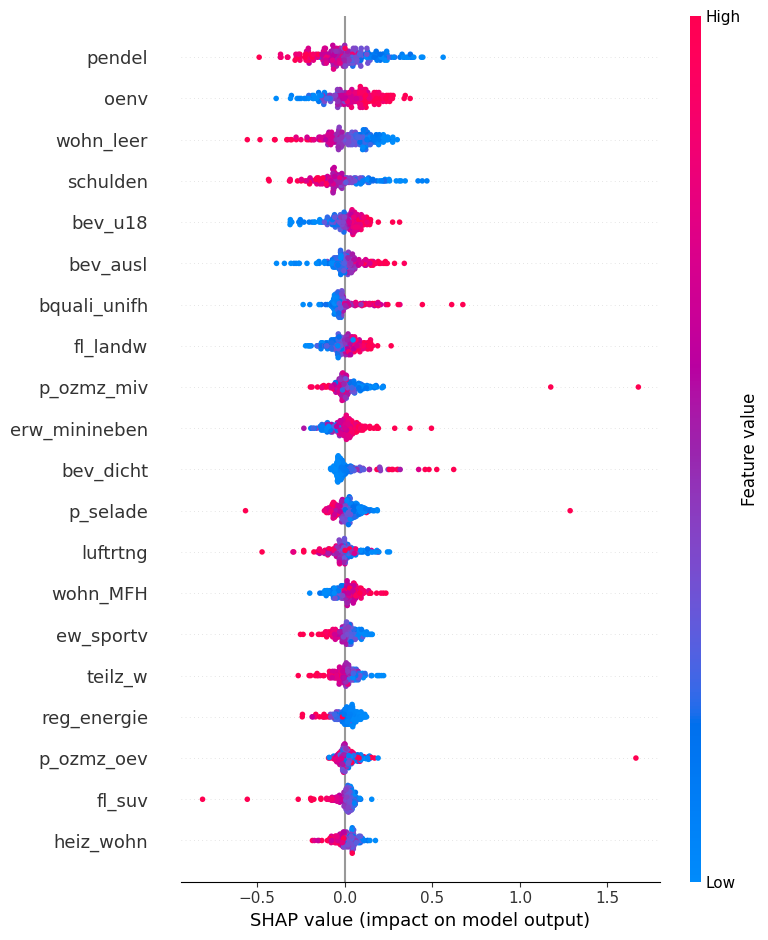

In [51]:
import shap

import matplotlib.pyplot as plt

# Dot plot: SHAP value on x-axis, color for feature value, sorted by SHAP importance

# Get top 20 features sorted by SHAP importance
top_features = shap_importances_series.head(20).index.tolist()
top_indices = [features.index(f) for f in top_features]

shap.summary_plot(
    shap_values.values[:, top_indices],
    X_val_sample[:, top_indices],
    feature_names=top_features,
    plot_type="dot"
)


In [ ]:
import matplotlib.pyplot as plt

# Get indices for 'schulden' and 'hh_veink'
schulden_idx = features.index('schulden')
hh_veink_idx = features.index('hh_veink')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    shap_values.values[:, schulden_idx],
    shap_values.values[:, hh_veink_idx],
    c=shap_values.data[:, hh_veink_idx],
    s=20 + 80 * (shap_values.data[:, schulden_idx] - shap_values.data[:, schulden_idx].min()) / (np.ptp(shap_values.data[:, schulden_idx]) + 1e-8),
    cmap='viridis',
    alpha=0.7
)
plt.xlabel("SHAP value for 'schulden'")
plt.ylabel("SHAP value for 'hh_veink'")
plt.title("SHAP Dependence: schulden vs hh_veink (color=hh_veink, size=schulden value)")
cbar = plt.colorbar(scatter)
cbar.set_label("'hh_veink' feature value")
plt.tight_layout()
plt.show()